<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Travel_Itinerary_Planner_Multi_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. State Graph: The core of our application, defining the flow of our Travel Planner.
2. Planner State: A custom type representing the state of our planning process.
3. Node Functions: Individual steps in our planning process ( input_city, input_interests, create_itinerary)

4 . LLM Integration: Utilizing a language model to generate the final itinerary.

In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [3]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00


In [15]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate,ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_groq import ChatGroq

Define Agent

In [6]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary:str

In [10]:
#Load groq api key from userdata colab
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get('groq_api_key')

In [13]:

llm = ChatGroq(
    temperature=0,
    model_name= "llama-3.3-70b-versatile"
)

result = llm.invoke("What is Multi AI Agent?")
result.content

"A Multi-Agent System (MAS) is a system composed of multiple intelligent agents that interact with each other and their environment to achieve common or individual goals. In the context of artificial intelligence (AI), a Multi-AI Agent refers to a system that consists of multiple AI agents that work together to solve complex problems, make decisions, or perform tasks.\n\nCharacteristics of Multi-AI Agents:\n\n1. **Autonomy**: Each AI agent has its own autonomy to make decisions and take actions.\n2. **Interactions**: AI agents interact with each other, sharing information, coordinating actions, and negotiating goals.\n3. **Distributed problem-solving**: Multiple AI agents work together to solve complex problems that are difficult or impossible for a single agent to solve.\n4. **Decentralized control**: There is no centralized control, and each AI agent makes its own decisions based on local information and interactions with other agents.\n\nTypes of Multi-AI Agents:\n\n1. **Cooperative

In [17]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("user", "Create an itinerary for my day trip.")
])

Define Agent Function

In [20]:
def input_city(state:PlannerState)->PlannerState:
  print("Please enter the city you want to visit for your day trip:")
  user_message = input("Your Input:")
  return{
      **state,
      "city":user_message,
      "messages":state["messages"]+[HumanMessage(content=user_message)]
  }

def input_interest(state:PlannerState)->PlannerState:
  print(f"Please enter your interest for the trip to: {state['city']} (comma-separated):")
  user_message = input("Your Input:")
  return{
      **state,
      "interest":[interest.strip() for interest in user_message.split(",")],
      "messages":state['messages']+[HumanMessage(content=user_message)]
  }

def create_itinerary(state:PlannerState)->PlannerState:
  print(f"Creating an itinerary for your day trip to {state['city']} based on interests: {', '.join(state['interests'])}")
  response=llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=', '.join(state['interests'])))
  print("Final Itinerary:")
  print(response.content)
  return{
      **state,
      "messages":state['messages']+[AIMessage(content=response.content)],
      "itinerary":response.content,
  }

Create and Compile the Graph

In [23]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interest",input_interest)
workflow.add_node("create_itinerary",create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city","input_interest")
workflow.add_edge("input_interest","create_itinerary")
workflow.add_edge("create_itinerary",END)

app = workflow.compile()

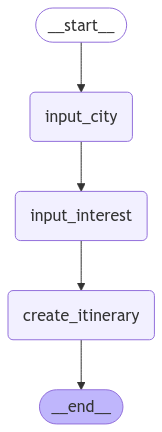

In [24]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Define the function thats run the graph

In [25]:
def travel_planner(user_request:str):
  print(f"Initial Request: {user_request}\n")
  state={
      "messages":HumanMessage(content=user_request),
      "city":"",
      "interests":[],
      "itinerary":"",
  }

  for ouput in app.stream(state):
    pass

In [26]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip:
Your Input:Hyderabad
Please enter your interest for the trip to: Hyderabad (comma-separated):
Your Input:Tank Bund Area Visit, With four friends, Affordable
Creating an itinerary for your day trip to Hyderabad based on interests: 
Final Itinerary:
Since you didn't specify any particular interests, I'll create a general itinerary that covers a mix of history, culture, and entertainment in Hyderabad. Here's a brief, bulleted itinerary for your day trip:

* 9:00 AM - 10:00 AM: Visit the Charminar, a historic monument and iconic symbol of Hyderabad
* 10:30 AM - 12:00 PM: Explore the Laad Bazaar, a traditional market filled with colorful bangles, jewelry, and handicrafts
* 12:30 PM - 1:30 PM: Have lunch at a local restaurant, trying some of Hyderabad's famous biryani and other cuisine
* 2:00 PM - 4:00 PM: Visit the Salar Jung Museum, which showcases a vast collection of art and artifacts f

In [27]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [30]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate, ChatPromptTemplate

# Define the PlannerState type
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile"
)

# Define the prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("user", "Create an itinerary for my day trip.")
])

# Define the state processing functions
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state["messages"] + [HumanMessage(content=user_message)]
    }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state["messages"] + [HumanMessage(content=user_message)]
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for your day trip to {state['city']} based on interests: {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=', '.join(state['interests'])))
    print("Final Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize the state
    state: PlannerState = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the inputs
    state["city"] = city
    state["interests"] = [interest.strip() for interest in interests.split(",")]

    # Generate itinerary
    state = create_itinerary(state)

    return state["itinerary"]

interface = gr.Interface(
    fn=travel_planner,
    theme="huggingface",
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter Your Interests (Comma-Separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),  # Corrected to 'outputs'
    title="Travel Itinerary Planner",
    description="Enter the city and interests to generate a personalized day trip travel itinerary.",
)

# Launch the Gradio interface
interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:1049: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-676b8ab4-7bceca096416d3622169f330;6a45c387-24ca-49cd-9c41-d0074652dd09)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c4e5fcc6f8d36fe236.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
